# Tarea 3 MLp 
### Nicolas Caro

## Libreria, Carga y Grafica de Datos 

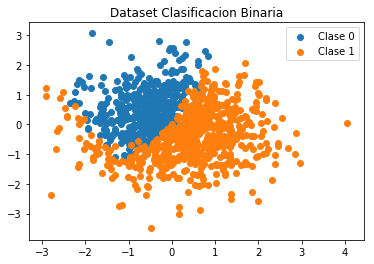

In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

from scipy.optimize import minimize
from scipy import stats

from pymc3.stats import autocorr
from itertools import product

from sklearn.metrics import precision_score

# Descarga de datos

import io
import requests

# Reproducir samples
import random
random.seed('MA5203')

# Carga de Datos 

link = "https://www.u-cursos.cl/ingenieria/2018/1/MA5203/1/tareas/r/datosT3_.txt"
info = requests.get(link).content

data = pd.read_csv(io.StringIO(info.decode()), header = None)
data = data.T

fig1 = plt.figure()
plt.title('Dataset Clasificacion Binaria')
data_c0 = data[data[2]==0]
plt.scatter(data_c0[0],data_c0[1], label= 'Clase 0')
data_c1 = data[data[2]==1]
plt.scatter(data_c1[0],data_c1[1],label= 'Clase 1')
plt.legend()

data_X = np.vstack((data[0],data[1])).T
data_Y = data[2]

# Datos iniciales
X = np.vstack((np.ones(data_X.shape[0]).T,data_X.T)).T
Y = data_Y

## Funciones Preliminares

In [77]:
# Sigmoide
sigmoid = lambda x : 1 / (1 + np.exp(-x))

# Construccion de la NLL
def NLL(X,Y,w):
    S=0
    for i in range(X.shape[0]):
        S += -(Y[i]*np.log(sigmoid(w.T @ X[i])) 
             + (1-Y[i])*np.log(1-sigmoid(w.T @ X[i])))

    return S

# Clasificador Logistico
def log_reg(X,w):
    '''
    Clasificador Logistico
    '''
    # Se añade un epsilon para aproximar 0.5 --> 1
    eps = 10**(-9)
    probs = np.array([sigmoid(w.T @ X[i]) for i in (range(X.shape[0]))])
    
    classes = np.round(probs+eps)
    
    return {'probs':probs,'classes':classes}

# Linea de Desicion dado w
def log_line(x,w):
    '''
    Linea de Desicion
    '''
    return (w[0] + w[1]*x)/(-w[2])

# Grafica de la linea de decision
def plot_w(w, c = 'black', label = 'Linea de Decisión',lb = -4.5, ub = 4.5, stp = 100 ):
    '''
    Funcion auxiliar para graficar la linea de decision
    '''
    xx = np.linspace(-4.5,4.5,100)
    return plt.plot(xx,log_line(xx,w),label= label,c = c)

# Prior Gaussiana sobre w
def prior_w_0(w,mu_w, sigma_w):
    '''
    Prior Gaussiana con media mu_w y covarianza esferica sigma_w**2 I
    '''    
    return stats.multivariate_normal(mean= mu_w, cov = (sigma_w**2)*np.eye(w.shape[0])).pdf(w)

# Funcion de verosimilitud
def L_0(w,X,Y):
    '''
    Verosimilitud:
    P(Y|W,X) 
    '''    
    N = X.shape[0]
    M = 1
    for i in range(N):
        S  = sigmoid(w.T @ X[i])
        M *= (S**Y[i])*((1-S)**(1-Y[i]))
    
    return M

# Proposoal Gaussiana para Metropolis
def MH_prop_0(x_t_1,prop_sigma):
    '''    
    Proposal Gaussiana
    q(x_t,x_t_1) = N(x_t|x_t_1,prop_sigma**2 I_3 )
    
    '''
    x_t = stats.multivariate_normal(mean= x_t_1, 
                                    cov = (prop_sigma**2)*np.eye(x_t_1.shape[0]))
    return x_t.rvs()

# Sampling usando MCMC
def MCMC(w_t,mu_w,sigma_w,prop_sigma,samples, C = 1):
    '''
    MCMC para muestrear w de dimension 3 con prior y proposal gaussianas.
        
    w_t: punto inicial
    mu_w: media prior
    sigma_w: desviacion estandar prior
    samples: cantidad de muestras
    '''    
    # Prior y Proposal
    prior_w = lambda w: prior_w_0(w,mu_w,sigma_w)
    MH_prop = lambda x_t : MH_prop_0(x_t,prop_sigma)

    # Configuraciones MCMC

    MCMC_mat = np.zeros((samples+1,3)).T
    MCMC_mat[:,0] = w_t

    # Contador de puntos aceptados
    A=0
    for i in range(samples):    

        w_c = MH_prop(w_t)
    
        # obs: Proposal simetrica! q se cancela    
        p_c = C*L(w_c)*prior_w(w_c)
        p_t = C*L(w_t)*prior_w(w_t) 
        
        r = min(1,p_c/p_t)
        if np.random.uniform(0,1) < r:
            w_t = w_c
            A+=1
    
        MCMC_mat[:,i+1] = w_t
        
    return {'ac_r':A/samples,'MCMC_mat':MCMC_mat}

## Pregunta 1

**a)** Se implementa un modelo de regresión logı́stica para clasificar los datos. Para ello, se construye la función de log-verosimilitud (negativa) y se estiman los parámetros de la regresión logística
utilizando L-BFGS-B. 

In [78]:
# Paramatrizacion de funciones

# Verosimilitud parametrizada por los datos iniciales X,Y.
L = lambda w: L_0(w,X,Y)

# Optimizacion con L-BFGS-B
J = lambda w: NLL(X,Y,w)

w0 = np.array([0,1, -1])

h = minimize(fun = J, x0 = w0, method='L-BFGS-B')
w=h.x # Vector de pesos obtenido

print(w)

[ 0.71664991  2.23176506 -2.19648242]


Se grafica la recta que separa ambas clases obtenida por maxima verosimilitud.

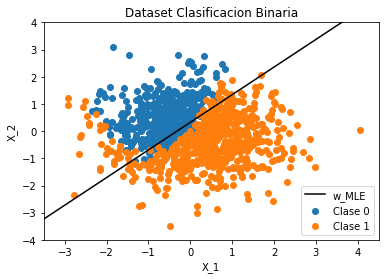

In [79]:
fig2 = plt.figure()
plt.title('Dataset Clasificacion Binaria')
data_c0 = data[data[2]==0]
plt.scatter(data_c0[0],data_c0[1], label= 'Clase 0')
data_c1 = data[data[2]==1]
plt.scatter(data_c1[0],data_c1[1],label= 'Clase 1')

plot_w(w, label='w_MLE')

ax = plt.gca()
ax.set_xlim([-3.5,4.5]); ax.set_ylim([-4,4])
plt.xlabel('X_1');plt.ylabel('X_2'); plt.legend()

No es posible clasificar correctamente todos los datos, esto de debe a que los datos se encuentran separados de manera no lineal. Una transformacion no lineal sobre los datos antes de entrenar los pesos de la regresion logistica podria solucionar este problema.

**c)** + **d)** Se implementa el algoritmo de Metropolis-Hastings para estimar la densidad a posteriori del modelo
encontrado en **a)**. La cadena de Markov se inicializa usando $\hat{w}^{ML}$. La implementacion especifca se encuentra en la seccion **Funciones Preliminares** bajo el nombre de MCMC. Para medir el efecto de las varianzas prior y proposal, se genera una grilla de valores para estos valores, para cubrir distintas escalas de valor se seleccionan potencias de 10 partiendo por $10^{-2}$ hasta $100$. Se busca una combiacion de varianza prior/proposal que mantenga una razon de aceptacion de muestras cercana al $50\%$.

In [80]:
# Configuraciones prior y proposal

# Valores para la varianza prior
prior_grid = np.array([10**i for i in range(-2,3)])

# Valores para la varianza proposal
prop_grid = prior_grid

# Como punto inicial se usa la recta obtenida por maxima verosimilitud.
w_t = w
# Se buscan rectas en torno a la recta (linea de decision) nula.
mu_w = np.array([0,0,0])

# Samples MCMC
samples = 1000
    
ac_r = []    
for sigma_w, sigma_prop in product(prior_grid,prop_grid):
    # Algoritmo MH (en este caso solo Metropolis)
    mcmc_res = MCMC(w_t,mu_w,sigma_w,sigma_prop,samples, C = 10**(100))

    # Proporcion de muesras aceptadas
    ac_r.append(np.array([mcmc_res['ac_r'], sigma_w,  sigma_prop]))
# Primera columna ac_r, segunda sigma prior, tercera sigma proporsal
tabla_ac_r = np.array(ac_r)

In [74]:
print(tabla_ac_r)

[[  1.00000000e+00   1.00000000e-02   1.00000000e-02]
 [  1.00000000e+00   1.00000000e-02   1.00000000e-01]
 [  1.00000000e+00   1.00000000e-02   1.00000000e+00]
 [  1.00000000e+00   1.00000000e-02   1.00000000e+01]
 [  1.00000000e+00   1.00000000e-02   1.00000000e+02]
 [  1.00000000e+00   1.00000000e-01   1.00000000e-02]
 [  1.00000000e+00   1.00000000e-01   1.00000000e-01]
 [  1.00000000e+00   1.00000000e-01   1.00000000e+00]
 [  1.00000000e+00   1.00000000e-01   1.00000000e+01]
 [  1.00000000e+00   1.00000000e-01   1.00000000e+02]
 [  9.48000000e-01   1.00000000e+00   1.00000000e-02]
 [  5.04000000e-01   1.00000000e+00   1.00000000e-01]
 [  3.00000000e-03   1.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   1.00000000e+01]
 [  0.00000000e+00   1.00000000e+00   1.00000000e+02]
 [  9.52000000e-01   1.00000000e+01   1.00000000e-02]
 [  4.98000000e-01   1.00000000e+01   1.00000000e-01]
 [  0.00000000e+00   1.00000000e+01   1.00000000e+00]
 [  0.00000000e+00   1.00000

Se elige una prior gaussiana para tener una dinamica simple y controlada por una varianza intuituva en la observación de rectas (muestras en la posterior), esto a la vez entrega simetria en la proposal, lo cual simplica los calculos. Por otro lado, la eleccion de las varianzas prior y proposal se hace por busqueda exaustiva, buscando un coeficiente de aceptacion de muestras cercano al $50\%$ a la vez que se busca una varianza prior suficientemente grande para permitir busquedas en lineas de decision distintas a la de maxima verosimilitud y una varianza proposal no tan pequeña, de manera que se pueda explorar lo más posible en el soporte de la posterior manteniendo alta la razon de aceptacion de muestras. Basado en esto, se escoge:

In [34]:
sigma_w = 10
sigma_prop = 0.1

mcmc_res = MCMC(w_t,mu_w,sigma_w,sigma_prop,samples)

print(mcmc_res['ac_r'])
MCMC_mat = mcmc_res['MCMC_mat']

0.529


Se muestra la traza para cada parametro:

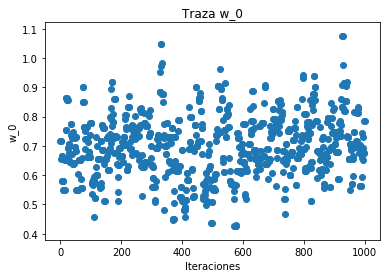

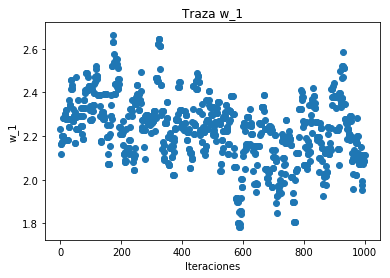

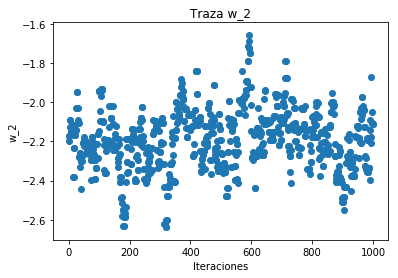

In [41]:
xx = np.arange(0, MCMC_mat.shape[1])

for i in range(3):
        plt.figure()
        plt.title('Traza w_' + str(i))
        plt.xlabel('Iteraciones'); plt.ylabel('w_' + str(i))
        plt.scatter(x=xx, y = MCMC_mat[i,:])

Las trazas muestran que la varianza a priori permite la exploración de nuevos valores en la distribucion posterior, mientras que la varianza proposal permite agregar una buena razon de muestras pues no se ven lineas de datos horizontales en torno a un solo valor. Finalmente la dispersión en estos graficos permite seleccionar como periodo de quemado razonable desde la iteración $100$ para $w_0$, $200$ para $w_1$ y $250$ para $w_2$ pues es desde esta iteracion que los coeficientes se comportan de manera mas regular en torno al estimador MLE.

## Graficos de Autocorrelación

Se producen graficos de autocorrelación y senselecciona aquel indice con autocerrelación más cercana a cero para adelgazar la cadena.

p =  [ 16.  29.  48.]


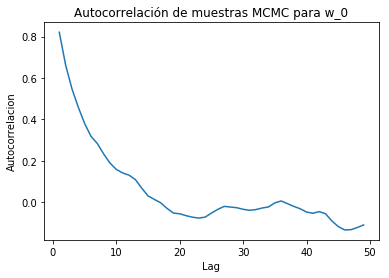

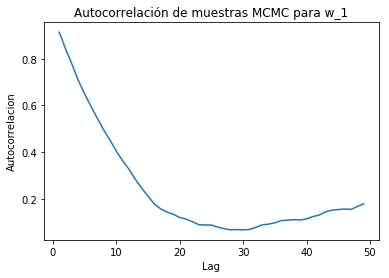

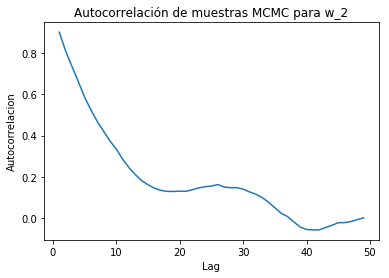

In [59]:
lags = np.arange(1,50)
p = np.zeros(3)

for j in range(3):
    
    fig, ax = plt.subplots()

    ax.plot(lags, [autocorr(MCMC_mat[j],l) for  l in lags])
    
    plt.title('Autocorrelación de muestras MCMC para w_' + str(j))
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelacion')
    
    p[j] = np.abs([autocorr(MCMC_mat[j],l) for  l in lags]).argmin()

print('p = ',p)

Se Grafican algunas rectas obtenidas por MCMC, estas se contrastan con el estimador MLE:

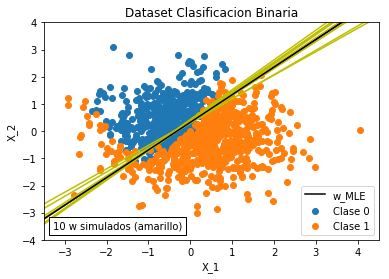

In [60]:
# Plot de lineas de decision obtenidas de la distribucion posterior

fig3 = plt.figure()
plt.title('Dataset Clasificacion Binaria')
data_c0 = data[data[2]==0]
plt.scatter(data_c0[0],data_c0[1], label= 'Clase 0')
data_c1 = data[data[2]==1]
plt.scatter(data_c1[0],data_c1[1],label= 'Clase 1')

plot_w(w, label='w_MLE')

ax = plt.gca()
ax.set_xlim([-3.5,4.5]); ax.set_ylim([-4,4])
plt.xlabel('X_1');plt.ylabel('X_2'); plt.legend()

# Se plotean 'num' muestras MCMC
num = 10

for i in range(num):
    j = np.random.choice(np.arange(samples))
    plot_w(MCMC_mat[:,j], c ='y')

txt = AnchoredText(str(num) + ' w simulados (amarillo)', loc= 3)
ax.add_artist(txt)

plot_w(w, label='w_MLE')

## Histogramas o Aproximación Posterior

Según la información obtenida por las trazas, se procede a quemar y adelgazar la cadena para obtener las muestras de la distribución posterior.

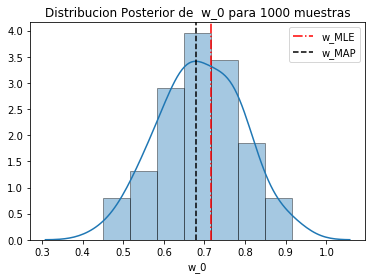

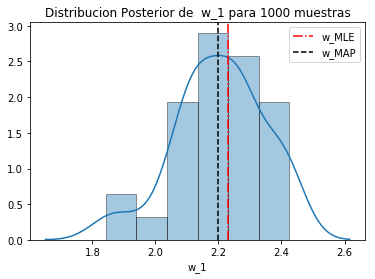

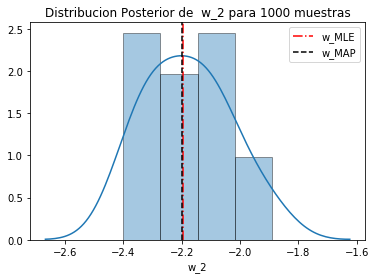

In [61]:
# Histogramas

# p representa el indice para adelgazar la cadena

# t_0 representa el punto inicial, anterior a t_0 se 'quema' la cadena
t_0 = np.array([100, 100, 250])

w_map = np.zeros(3)
sample_mat = []
for j in range(3):

    MCMC_mat_thin=MCMC_mat[j][t_0[j]::int(p[j])]
    sample_mat.append(MCMC_mat_thin)
    
    fig, ax = plt.subplots()
    
    # Se produce una figura y se guarda el histograma generado ''H''
    H = sns.distplot(MCMC_mat_thin, hist=True, kde=True, 
                     hist_kws={'edgecolor':'black'}).get_lines()[0].get_data()
    
    plt.title('Distribucion Posterior de  w_' + str(j) + ' para ' + str(samples) + ' muestras')
    plt.xlabel('w_' + str(j))
    
    # Se obtiene el Map segun el histograma generado
    w_map[j] = H[0][H[1].argmax()]
    
    ax.axvline(x=w[j], label='w_MLE', ls= '-.', c = 'r')
    ax.axvline(x=w_map[j], label = 'w_MAP',ls= '--', c='black')
    ax.legend()

El estimador MAP difiere en general del obtenido por MLE, la presición de clasificación obtenida en ambos casos:

In [70]:
Y_pred_MLE = log_reg(X,w)
Y_pred_MAP = log_reg(X,w_map)

p_MLE = precision_score(y_pred= Y_pred_MLE['classes'], y_true=Y)
p_MAP = precision_score(y_pred= Y_pred_MAP['classes'], y_true=Y)

print(' p_MAP = ' + str(p_MAP), '\n','p_MLE = ' + str(p_MLE))

 p_MAP = 0.88698630137 
 p_MLE = 0.882653061224


Se concluye que el estimador MAP obtenido por MCMC presenta mayor precision.